In [90]:

import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
from scipy.ndimage.filters import gaussian_filter
import json

plt.ion()

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx
    
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc




In [91]:
from scipy.ndimage.filters import gaussian_filter

In [92]:
#For our window we are going to do a blackman window because it 
#minimizes spectral leakage
def window(n):
    x=np.arange(n)
    return 0.42 -0.5*np.cos(2*np.pi*x/(n-1))+0.08*np.cos(4*np.pi*x/(n-1))

In [93]:
def noise_model(strain,win):


    #We can expect the noise to be the power spectrum of the data
    noise=np.abs(np.fft.rfft(win*strain))**2

    #To smooth out we are going to use a gaussian filter 
    #It works by taking a convolution of the the data
    #with the a gaussina kernel
    #I pick a sigma of 10 
    smooth_noise = gaussian_filter(noise, 10)


    return smooth_noise


In [94]:
def MF(data,template,dt):

    n = len(data)
    win = window(n)
    data_ft = np.fft.rfft(win*data)

    noise = noise_model(data,win)

    #Converting fourier space to frequency space
    tobs=dt*n
    dnu=1/tobs
    nu=np.arange(len(noise))*dnu
    nu[0]=0.5*nu[1]

    #Getting rid of out range frequency where the noise is 
    #due to instruments 
    Ninv=1/noise
    Ninv[nu>1500]=0
    Ninv[nu<20]=0

    #whitening the data
    dataFT_white=data_ft*np.sqrt(Ninv)
    templateFT_white=np.fft.rfft(template*win)*np.sqrt(Ninv)

    mf = np.fft.fftshift(np.fft.irfft(np.conj(templateFT_white)*dataFT_white))


    return mf, noise, templateFT_white

In [95]:
def SNR(mf,tmp):
    #Following Prof. Sievers mf_eample.py the anslytical 
    #noise should be template@template, here Ninv is already in cause I am using the whiten template
    anlytical_noise = abs(tmp@tmp)

    SNR_anal = np.max(mf)/anlytical_noise

    SNR_mf = np.max(mf)/np.std(mf[30000:100000])

    return SNR_anal, SNR_mf


In [96]:
def combiningSNRS(SNR1,SNR2):
    return np.sqrt(SNR1**2 + SNR2**2)

------------------------- GW150914 -----------------------------------
Analytic SNR for Livingston: 6.285545272273284e-07
Analytic SNR for Hanford: 2.385518201021005e-07
Data estimate SNR for Livingston: 16.98024320477205
Data estimate SNR for Hanford: 11.810262105113374
Analytic SNR_L+SNR_H: 6.72300352946505e-07
Data estimate SNR_L+SNR_H: 20.683591329473817
------------------------- LVT151012 -----------------------------------
Analytic SNR for Livingston: 3.0700761245994466e-08
Analytic SNR for Hanford: 6.869970125968541e-08
Data estimate SNR for Livingston: 4.854440849129895
Data estimate SNR for Hanford: 8.26945590071417
Analytic SNR_L+SNR_H: 7.524749626568034e-08
Data estimate SNR_L+SNR_H: 9.589030026627167
------------------------- GW151226 -----------------------------------
Analytic SNR for Livingston: 2.3648646372387979e-07
Analytic SNR for Hanford: 1.8400284553411008e-06
Data estimate SNR for Livingston: 4.875015708927413
Data estimate SNR for Hanford: 12.467809153451919
Anal

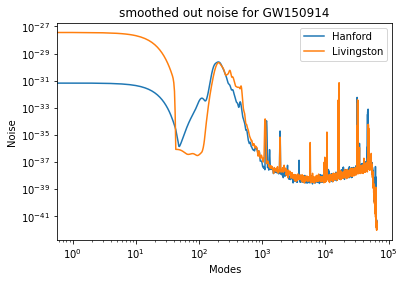

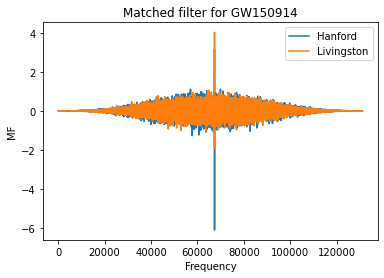

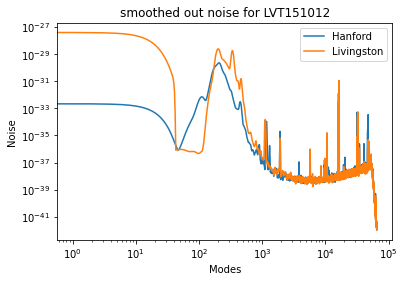

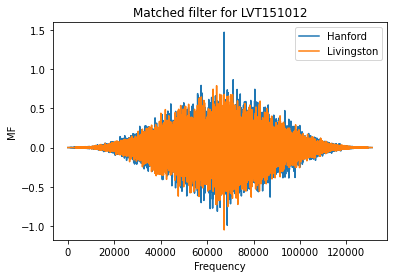

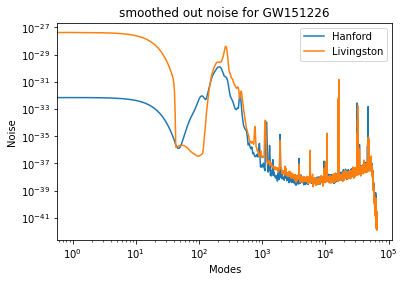

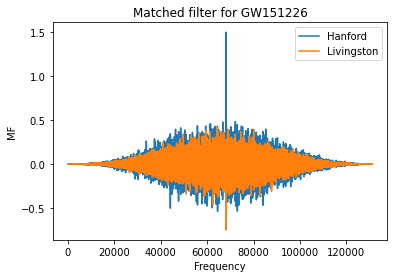

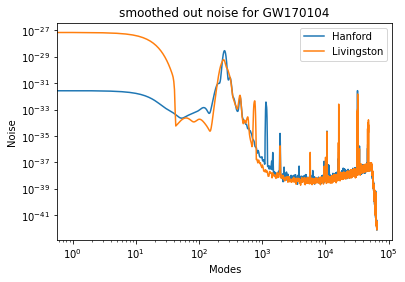

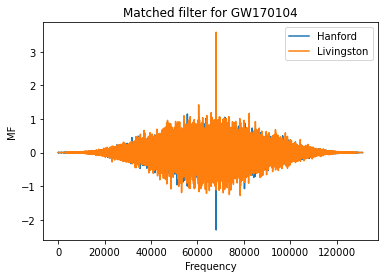

In [97]:
import json

events = json.load(open('/home/nicolas/Documents/myCompPhysrepo/phys512-2022/PSET6/LOSC_Event_tutorial/BBH_events_v3.json'))

for event_name in events:

    root = "./LOSC_Event_tutorial/"

    strain_h,dt_h,utc_h = read_file("%s/%s" %(root, events[event_name]['fn_H1']))
    

    strain_l,dt_l,utc_l = read_file("%s/%s" %(root, events[event_name]['fn_L1']))

    tp,tx = read_template("%s/%s" %(root, events[event_name]['fn_template']))

    mf_h, noise_h, templateFT_white_h = MF(strain_h,tp,dt_h)
    mf_l, noise_l, templateFT_white_l = MF(strain_l,tp,dt_l)


    plt.figure()
    plt.loglog(noise_h, label = "Hanford")
    plt.loglog(noise_l, label="Livingston")
    plt.title("smoothed out noise for %s" %event_name)
    plt.xlabel("Modes")
    plt.ylabel("Noise")
    plt.legend()
    plt.show

    plt.figure()
    plt.plot(mf_h, label = "Hanford")
    plt.plot(mf_l, label="Livingston")
    plt.title("Matched filter for %s" %event_name)
    plt.xlabel("Frequency")
    plt.ylabel("MF")
    plt.legend()
    plt.show

    Analytic_SNR_L, MF_SNR_L = SNR(mf_l,templateFT_white_l)
    Analytic_SNR_H, MF_SNR_H = SNR(mf_h,templateFT_white_h)
    Analytic_combinaition_SNR = combiningSNRS(Analytic_SNR_L,Analytic_SNR_H)
    data_SNR_combinaition = combiningSNRS(MF_SNR_H, MF_SNR_L)

    print("------------------------- %s -----------------------------------" %event_name)
    print("Analytic SNR for Livingston:", Analytic_SNR_L)
    print("Analytic SNR for Hanford:", Analytic_SNR_H)
    print("Data estimate SNR for Livingston:", MF_SNR_L)
    print("Data estimate SNR for Hanford:", MF_SNR_H)
    print("Analytic SNR_L+SNR_H:", Analytic_combinaition_SNR)
    print("Data estimate SNR_L+SNR_H:", data_SNR_combinaition)


    

